# GIGO revisited
## Script 2: Main data processing and analysis

### Install dependencies
See `requirements.txt` for specific version numbers

In [1]:
!pip install pandas seaborn openpyxl simpledorff

### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import ticker

### Load and explore data

In [3]:
df = pd.read_excel("../data/final_labels_hashed.xlsx", keep_default_na=False)

In [4]:
df.sample(2).T

,154,169
original row,156,171
URL hash,b583a99feeeda11b0eb9e058121ed0cbdf035fef2c732e...,07594aa088ecf2cc4ae5acb8d851df75d850d6cf02fecd...
original classification task,yes,no
classification outcome,Linguistic,N/A
labels from human annotation,No information (implicit),N/A
human annotation for training vs. eval,HA for training data,N/A
used original human annotation,Only external,N/A
approach to training data,External human-labeled data,No ML classifier
original human annotation source,N/A,N/A
prescreening for crowdwork,N/A,N/A


### Clean data
First, format the column name "formal instructions" properly

In [5]:
df.rename(columns = {'formal Instructions ':'formal instructions'}, inplace = True)

In [6]:
df.columns

Index(['original row', 'URL hash', 'original classification task',
       'classification outcome', 'labels from human annotation',
       'human annotation for training vs. eval',
       'used original human annotation', 'approach to training data',
       'original human annotation source', 'prescreening for crowdwork',
       'annotator compensation', 'training for human annotators',
       'formal instructions', 'multiple annotator overlap',
       'synthesis of annotator overlap', 'reported inter-annotator agreement',
       'total num of human annotators', 'median num of annotators per item',
       'link to dataset available', 'Corpus', 'Year', 'Document Type',
       'Cited by', 'Access Type'],
      dtype='object')

In the corpus field, "Social Science" should be "Soc Sci & Humanities" and "Biomedical" should be "Life Sci & Biomedical"

In [7]:
df['Corpus'].replace(to_replace='Social Science',value='Soc Sci & Humanities',inplace=True)
df['Corpus'].replace(to_replace='Biomedical',value='Life Sci & Biomedical',inplace=True)

In [8]:
df['Corpus'].value_counts()

Physical & Enviro Sci    70
Soc Sci & Humanities     70
Life Sci & Biomedical    60
Name: Corpus, dtype: int64

In [9]:
def approach_to_data(row):
    """
    Classifies an item's approach to datasets, based on the intersection of multiple questions
    
    Parameters:
        row (pd.Series): row that includes 'labels from human annotation' and 'used original human annotation'
        
    Returns:
        approach (str): one of a set of defined categories
    """
    
    if row['labels from human annotation'] == 'N/A':
        return "No ML classifier / N/A"
    elif row['labels from human annotation'] == 'No / machine-labeled':
        return "Machine-labeled data"   
    elif row['labels from human annotation'] == 'Yes for all items' or row['labels from human annotation'] == 'Yes for some items':
        human_labeled = True
    elif row['labels from human annotation'] == 'No information (implicit)':
        human_labeled = True
    else:
        human_labeled = np.nan
    
    if row['used original human annotation'] == 'Only original':
        original_labeling = True
    elif row['used original human annotation'] == 'Original and external':
        original_labeling = True
    elif row['used original human annotation'] == 'Only external':
        original_labeling = False
    elif row['used original human annotation'] == 'Unsure':
        return "Unsure"
    
    if human_labeled and original_labeling:
        return "Original human-labeled dataset"
    elif human_labeled and not original_labeling:
        return "External human-labeled data"
    else:
        return ("ERROR")
        

Test the function:

In [10]:
df[['labels from human annotation','used original human annotation']].iloc[[1,3,93,8,43,31,18]]

,labels from human annotation,used original human annotation
1,Yes for some items,Only external
3,Yes for all items,Only original
93,No / machine-labeled,N/A
8,N/A,N/A
43,No information (implicit),Only external
31,Yes for all items,Original and external
18,No information (implicit),Unsure


Should be: 

- External human-labeled data
- Original human-labeled dataset
- Machine-labeled data
- No ML classifier / N/A
- External human-labeled data
- Original human-labeled dataset
- Unsure

In [11]:
df[['labels from human annotation','used original human annotation']].iloc[[1,3,93,8,43,31,18]].apply(approach_to_data,axis=1)

1        External human-labeled data
3     Original human-labeled dataset
93              Machine-labeled data
8             No ML classifier / N/A
43       External human-labeled data
31    Original human-labeled dataset
18                            Unsure
dtype: object

In [12]:
df['approach to training data'] = df.apply(approach_to_data,axis=1)
df['approach to training data'].value_counts()

No ML classifier / N/A            59
External human-labeled data       58
Machine-labeled data              38
Original human-labeled dataset    38
Unsure                             7
Name: approach to training data, dtype: int64

### Label source score

In [13]:
def label_source_score(row):
    """
    Scores an item's approach to datasets, based on the answers from multiple questions
    
    Parameters:
        row (pd.Series): single row, to be used with df.apply(axis=1)
        
    Returns:
        score (int or np.nan): 1, 0, or np.nan
    """
    
    if row['original classification task'] != 'yes':
        return {'label source score':np.nan}
    
    if row['labels from human annotation'] == 'Yes for all items':
        return {'label source score':1}
    elif row['labels from human annotation'] == 'Yes for some items':
        return {'label source score':1}
    elif row['labels from human annotation'] == 'No / machine-labeled':
        return {'label source score':1}
    elif row['labels from human annotation'] == 'No information (implicit)':
        return {'label source score':0}
    elif row['labels from human annotation'] == 'Unsure':
        return {'label source score':0}
    elif row['labels from human annotation'] == 'N/A':
        return {'label source score':np.nan}

Test:

In [14]:
df[['original classification task','labels from human annotation']].iloc[[1,3,93,8,43]]

,original classification task,labels from human annotation
1,yes,Yes for some items
3,yes,Yes for all items
93,yes,No / machine-labeled
8,no,N/A
43,yes,No information (implicit)


Should be: 1, 1, 1, np.nan, 0.0

In [15]:
df[['original classification task','labels from human annotation']].iloc[[1,3,93,8,43]].apply(label_source_score,axis=1).apply(pd.Series)

,label source score
1,1.0
3,1.0
93,1.0
8,NaN
43,0.0


### Calculate label source score and append to dataframe

In [16]:
df = pd.concat([df,df.apply(label_source_score,axis=1).apply(pd.Series)],axis=1)

In [17]:
df.sample(2).T

,189,103
original row,191,105
URL hash,99c322f4045f7ce68bc5fb01ec9ccac35efe4afe0b9250...,c761344ccb65fed2d1c1afe4741ad4677bed9acd52a0f8...
original classification task,yes,no
classification outcome,Linguistic,N/A
labels from human annotation,No / machine-labeled,N/A
human annotation for training vs. eval,N/A,N/A
used original human annotation,N/A,N/A
approach to training data,Machine-labeled data,No ML classifier / N/A
original human annotation source,N/A,N/A
prescreening for crowdwork,N/A,N/A


In [18]:
def score_row(row):
    
    """
    Scores an item's paper information score, based on the answers from multiple questions
    
    Parameters:
        row (pd.Series): single row, to be used with df.apply(axis=1)
        
    Returns:
        score (int or np.nan): 1 to 13 or np.nan
    """
    
    score = 0
    max_score = 0
    
    if row['labels from human annotation'] == 'Yes for all items':
        score+=1
        max_score+=1
    elif row['labels from human annotation'] == 'Yes for some items':
        score+=1
        max_score+=1
    elif row['labels from human annotation'] == 'No / machine-labeled':
        return {"score":np.nan, "max score":np.nan, "norm score":np.nan}
    elif row['labels from human annotation'] == 'No information (implicit)':
        max_score+=1
    elif row['labels from human annotation'] == 'Unsure':
        max_score+=1
    elif row['labels from human annotation'] == 'N/A':
        return {"score":np.nan, "max score":np.nan, "norm score":np.nan}

    
    if row['human annotation for training vs. eval'] == 'N/A':
        return {"score":np.nan, "max score":np.nan, "norm score":np.nan}
    elif row['human annotation for training vs. eval'] == 'HA for training data':
        score+=1
        max_score+=1
    elif row['human annotation for training vs. eval'] == 'HA for evaluation only':
        score+=1
        max_score+=1        
    elif row['human annotation for training vs. eval'] == 'Unsure':
        max_score+=1

        
    if row['used original human annotation'] == 'Only external':
        return {"score":np.nan, "max score":np.nan, "norm score":np.nan}
    elif row['used original human annotation'] == 'Only original':
        score+=1
        max_score+=1
    elif row['used original human annotation'] == 'Original and external':
        score+=1
        max_score+=1
    elif row['used original human annotation'] == 'Unsure':
        max_score+=1
    
        
    if row['original human annotation source'] == "Paper's authors":
        score+=1
        max_score+=1
    elif row['original human annotation source'] == "Other w/ claim of expertise":
        score+=1
        max_score+=1
    elif row['original human annotation source'] == "Survey/self-reported":
        score+=1
        max_score+=1
    elif row['original human annotation source'] == "Other (no claim of expertise)":
        score+=1
        max_score+=1
    elif row['original human annotation source'] == 'No information':
        max_score+=1
      
    #no prescreening for crowdwork questions were applicable

    if row['annotator compensation'] == "Paper authorship":
        score+=1
        max_score+=1    
    elif row['annotator compensation'] == "Volunteer / explicit no compensation":
        score+=1
        max_score+=1    
    elif row['annotator compensation'] == 'No information':
        max_score+=1

        
    if row['training for human annotators'] == "some training details":
        score+=1
        max_score+=1    
    elif row['training for human annotators'] == 'No information':
        max_score+=1
  

    if row['formal instructions'] == "Instructions w/ formal definition or examples":
        score+=1
        max_score+=1   
    elif row['formal instructions'] == "no Instructions beyond question text":
        score+=1
        max_score+=1   
    elif row['formal instructions'] == 'No information':
        max_score+=1 
  
              
    if row['multiple annotator overlap'] == 'No':
        score+=1
        max_score+=1        
    elif row['multiple annotator overlap'] == 'Yes for all items':
        score+=1
        max_score+=1        
    elif row['multiple annotator overlap'] == 'Yes for some items':
        score+=1
        max_score+=1        
    elif row['multiple annotator overlap'] == 'No information':
        max_score+=1        

        
    if row['synthesis of annotator overlap'] == 'Qualitative / discussion':
        score+=1
        max_score+=1        
    elif row['synthesis of annotator overlap'] == 'Quantitative / no discussion':
        score+=1
        max_score+=1        
    elif row['synthesis of annotator overlap'] == 'No information':
        max_score+=1 

        
    if row['reported inter-annotator agreement'] == 'no':
        max_score+=1        
    elif row['reported inter-annotator agreement'] == 'yes':
        score+=1
        max_score+=1  
    
    if row['total num of human annotators'] == '-':
        max_score+=1
    elif str(row['total num of human annotators']).isnumeric:
        max_score+=1
        score+=1

    if row['median num of annotators per item'] == '-':
        max_score+=1
    elif str(row['median num of annotators per item']).isnumeric:
        max_score+=1
        score+=1    

    if row['link to dataset available'] == 'no':
        max_score+=1        
    elif row['link to dataset available'] == 'yes':
        score+=1
        max_score+=1  

        
    return {"score":score, "max score":max_score, "norm score":score/max_score}

Test function:

In [19]:
df.apply(score_row,axis=1).apply(pd.Series)

,score,max score,norm score
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,9.0,11.0,0.818182
4,NaN,NaN,NaN
...,...,...,...
195,NaN,NaN,NaN
196,10.0,13.0,0.769231
197,NaN,NaN,NaN
198,3.0,11.0,0.272727


Apply, calculate, and append to dataframe:

In [20]:
df = pd.concat([df,df.apply(score_row,axis=1).apply(pd.Series)],axis=1)

In [21]:
df.sample(2).T

,27,192
original row,29,194
URL hash,f5d4b49891a68c23180b74ee211f00fbe68f093cdc578c...,3ef4e7e71bb2038eac65ec360c8d73922b1ee23be5436c...
original classification task,yes,yes
classification outcome,Medical,Medical
labels from human annotation,No / machine-labeled,No / machine-labeled
human annotation for training vs. eval,N/A,N/A
used original human annotation,N/A,N/A
approach to training data,Machine-labeled data,Machine-labeled data
original human annotation source,N/A,N/A
prescreening for crowdwork,N/A,N/A


Create new dataframe for only papers involving original human annotation (answer to source will NOT be N/A)

In [22]:
df_original_ha = df.query("`original human annotation source` != 'N/A'")
df_original_ha

,original row,URL hash,original classification task,classification outcome,labels from human annotation,human annotation for training vs. eval,used original human annotation,approach to training data,original human annotation source,prescreening for crowdwork,...,link to dataset available,Corpus,Year,Document Type,Cited by,Access Type,label source score,score,max score,norm score
3,5,3714e16720b27a5a102dde1dd7cfe0201d52a65e4f486f...,yes,Medical,Yes for all items,HA for training data,Only original,Original human-labeled dataset,Survey/self-reported,N/A,...,no,Soc Sci & Humanities,2018,Article,3,,1.0,9.0,11.0,0.818182
10,12,0a633e25f6a59f2279f09f7f9c752d64404cd661055c57...,yes,Activities & actions,Yes for all items,HA for training data,Original and external,Original human-labeled dataset,Survey/self-reported,N/A,...,no,Physical & Enviro Sci,2016,Conference Paper,4,,1.0,8.0,11.0,0.727273
11,13,dfad9b6f70f13aa9fd02b74983afb2ad550dc9cf65848e...,yes,Geo/ecological,Yes for some items,HA for training data,Original and external,Original human-labeled dataset,No information,N/A,...,no,Physical & Enviro Sci,2014,Article,98,,1.0,3.0,11.0,0.272727
18,20,44a7dd495d27ecd2a02b21f7646b9946b32ed9a00c4a43...,yes,Medical,No information (implicit),HA for training data,Unsure,Unsure,No information,N/A,...,no,Physical & Enviro Sci,2017,Conference Paper,1,,0.0,1.0,11.0,0.090909
19,21,2bf50bdd57478d1ed4d71ccd2fdd091eb7393e17c589ff...,yes,Geo/ecological,Yes for all items,HA for training data,Only original,Original human-labeled dataset,Paper's authors,N/A,...,no,Physical & Enviro Sci,2016,Article,3,,1.0,5.0,11.0,0.454545
28,30,634d4b85851a652de814182c8d00034ea555f2754188fb...,yes,Medical,Yes for all items,HA for training data,Only original,Original human-labeled dataset,No information,N/A,...,no,Life Sci & Biomedical,2016,Conference Paper,6,,1.0,3.0,11.0,0.272727
31,33,05b6d96af36ec19da79de7a916f7e9c12df8f9137e755d...,yes,Linguistic,Yes for all items,HA for training data,Original and external,Original human-labeled dataset,No information,N/A,...,no,Life Sci & Biomedical,2015,Article,10,,1.0,3.0,11.0,0.272727
35,37,3b4459f85ecfdf47188183894b07e6e16d9c9bf7f78336...,yes,Activities & actions,Yes for all items,HA for training data,Only original,Original human-labeled dataset,Paper's authors,N/A,...,yes,Life Sci & Biomedical,2015,Article,13,Open Access,1.0,11.0,11.0,1.000000
45,47,04534e0fc91ecb4a775add6ad14a8a725f314aaaa5b925...,yes,Medical,Yes for all items,HA for training data,Only original,Original human-labeled dataset,Other w/ claim of expertise,N/A,...,no,Life Sci & Biomedical,2017,Article,14,,1.0,5.0,11.0,0.454545
54,56,ff814ba8796b46063484732fc6a560d0baff40adbe4435...,yes,Biological,Yes for all items,HA for training data,Only original,Original human-labeled dataset,Other (no claim of expertise),N/A,...,no,Soc Sci & Humanities,2016,Article,34,,1.0,10.0,11.0,0.909091


### Spot check
There should be seven papers that have 'unsure' approach to training data:


In [23]:
df_original_ha['approach to training data'].value_counts()

Original human-labeled dataset    38
Unsure                             7
Name: approach to training data, dtype: int64

There should be six papers that involved multiple annotators per item that have two additional questions applicable:

In [24]:
df_original_ha['max score'].value_counts()

11.0    39
13.0     6
Name: max score, dtype: int64

## Analysis and visualizations

### Main results viz

In [25]:
df[ 'original classification task'].value_counts()

yes    141
no      49
N/A     10
Name: original classification task, dtype: int64

In [26]:
questions = [ 'original classification task',
       'labels from human annotation',
       'human annotation for training vs. eval',
       'used original human annotation',
       'original human annotation source', 'prescreening for crowdwork',
       'annotator compensation', 'training for human annotators',
       'formal instructions', 'multiple annotator overlap',
       'synthesis of annotator overlap', 'reported inter-annotator agreement',
       'total num of human annotators', 'median num of annotators per item',
       'link to dataset available']

In [27]:
def summarize_row(row):
    """
    Recode an item's answers to various questions, in a way that reduces them to 
    answers of 'yes', 'no', 'unsure (assumed yes)', 'unsure / no information', or
    np.nan. This is a qualitative recoding that captures the same information as
    the paper information scores. \
    
    Parameters:
        row (pd.Series): single row, to be used with df.apply(axis=1)
        
    Returns:
        results_dict (dict): 15 item dictionary containing recoded values
    """
    results_dict = {}
    
    if row['original classification task'] == 'yes':
        results_dict['paper presented original classification task'] = 'yes'
    elif row['original classification task'] == 'no':
        results_dict['paper presented original classification task'] = 'no'
    else:
        results_dict['paper presented original classification task'] = np.nan
    
    if row['labels from human annotation'] == 'Yes for all items':
        results_dict['used labels from human annotation'] = 'yes'
    elif row['labels from human annotation'] == 'Yes for some items':
        results_dict['used labels from human annotation'] = 'yes'
    elif row['labels from human annotation'] == 'No / machine-labeled':
        results_dict['used labels from human annotation'] = 'no'
    elif row['labels from human annotation'] == 'No information (implicit)':
        results_dict['used labels from human annotation'] = 'yes'
    elif row['labels from human annotation'] == 'Unsure':
        results_dict['used labels from human annotation'] = 'unsure (assumed yes)'
    elif row['labels from human annotation'] == 'N/A':
        results_dict['used labels from human annotation'] = np.nan

    
    if row['human annotation for training vs. eval'] == 'N/A':
        results_dict['reported human annotation for training vs. eval'] = np.nan
    elif row['human annotation for training vs. eval'] == 'HA for training data':
        results_dict['reported human annotation for training vs. eval'] = 'yes'
    elif row['human annotation for training vs. eval'] == 'HA for evaluation only':
        results_dict['reported human annotation for training vs. eval'] = 'yes'     
    elif row['human annotation for training vs. eval'] == 'Unsure':
        results_dict['reported human annotation for training vs. eval'] = 'unsure / no information'

    if row['used original human annotation'] == 'Only external':
        results_dict['used external human annotation'] = 'yes'
    elif row['used original human annotation'] == 'Only original':
        results_dict['used external human annotation'] = 'no'
    elif row['used original human annotation'] == 'Original and external':
        results_dict['used external human annotation'] = 'yes'
    elif row['used original human annotation'] == 'Unsure':
        results_dict['used external human annotation'] = 'unsure / no information'
    else:
        results_dict['used external human annotation'] = np.nan
        
    if row['used original human annotation'] == 'Only external':
        results_dict['used original human annotation'] = 'no'
    elif row['used original human annotation'] == 'Only original':
        results_dict['used original human annotation'] = 'yes'
    elif row['used original human annotation'] == 'Original and external':
        results_dict['used original human annotation'] = 'yes'
    elif row['used original human annotation'] == 'Unsure':
        results_dict['used original human annotation'] = 'unsure (assumed yes)'
    else:
        results_dict['used original human annotation'] = np.nan


        
        
    if row['original human annotation source'] == "Paper's authors":
        results_dict['reported original human annotation source'] = 'yes'
    elif row['original human annotation source'] == "Other w/ claim of expertise":
        results_dict['reported original human annotation source'] = 'yes'

    elif row['original human annotation source'] == "Survey/self-reported":
        results_dict['reported original human annotation source'] = 'yes'

    elif row['original human annotation source'] == "Other (no claim of expertise)":
        results_dict['reported original human annotation source'] = 'yes'

    elif row['original human annotation source'] == 'No information':
        results_dict['reported original human annotation source'] = 'no'
    else:
        results_dict['reported original human annotation source'] = np.nan
      
    #no prescreening for crowdwork questions were applicable

    if row['annotator compensation'] == "Paper authorship":
        results_dict['reported annotator compensation'] = "yes"
    elif row['annotator compensation'] == "Volunteer / explicit no compensation":
        results_dict['reported annotator compensation'] = "yes"
    elif row['annotator compensation'] == 'No information':
        results_dict['reported annotator compensation'] = "no"
    else:
        results_dict['reported annotator compensation'] = np.nan


        
    if row['training for human annotators'] == "some training details":
        results_dict['reported training details'] = 'yes'
    elif row['training for human annotators'] == 'No information':
        results_dict['reported training details'] = 'no'
    else:
        results_dict['reported training details'] = np.nan
  

    if row['formal instructions'] == "Instructions w/ formal definition or examples":
        results_dict['reported formal instructions'] = 'yes' 
    elif row['formal instructions'] == "no Instructions beyond question text":
        results_dict['reported formal instructions'] = 'yes'   
    elif row['formal instructions'] == 'No information':
        results_dict['reported formal instructions'] = 'no' 
    else:
        results_dict['reported formal instructions'] = np.nan  
              
    if row['multiple annotator overlap'] == 'No':
        results_dict['used multiple annotator overlap'] = 'no'   
    elif row['multiple annotator overlap'] == 'Yes for all items':
        results_dict['used multiple annotator overlap'] = 'yes'      
    elif row['multiple annotator overlap'] == 'Yes for some items':
        results_dict['used multiple annotator overlap'] = 'yes'      
    elif row['multiple annotator overlap'] == 'No information':
        results_dict['used multiple annotator overlap'] = 'unsure / no information'  
    else:
        results_dict['used multiple annotator overlap'] = np.nan
        
    if row['synthesis of annotator overlap'] == 'Qualitative / discussion':
        results_dict['reported synthesis of annotator overlap']      = 'yes' 
    elif row['synthesis of annotator overlap'] == 'Quantitative / no discussion':
        results_dict['reported synthesis of annotator overlap']      = 'yes' 
    elif row['synthesis of annotator overlap'] == 'No information':
        results_dict['reported synthesis of annotator overlap']      = 'no' 
    else:
        results_dict['reported synthesis of annotator overlap'] = np.nan
        
    if row['reported inter-annotator agreement'] == 'no':
        results_dict['reported inter-annotator agreement'] = 'no'     
    elif row['reported inter-annotator agreement'] == 'yes':
        results_dict['reported inter-annotator agreement'] = 'yes'
    else:
        results_dict['reported inter-annotator agreement'] = np.nan
    
    if row['total num of human annotators'] == '-':
        results_dict['reported total number of annotators'] = 'no'
    elif str(row['total num of human annotators']).isnumeric():
        results_dict['reported total number of annotators'] = 'yes'
    else:
        results_dict['reported total number of annotators'] = np.nan


    if row['median num of annotators per item'] == '-':
        results_dict['reported median number of annotators'] = 'no'
    elif str(row['median num of annotators per item']).isnumeric():
        results_dict['reported median number of annotators'] = 'yes'
    else:
        results_dict['reported median number of annotators'] = np.nan

    if row['link to dataset available'] == 'no':
        results_dict['link to dataset available'] ='no'    
    elif row['link to dataset available'] == 'yes':
        results_dict['link to dataset available'] ='yes'    
    else:
        results_dict['link to dataset available'] =np.nan   


        
    return results_dict

In [28]:
l = []
for row in df.iterrows():
    l.append(summarize_row(row[1]))

In [29]:
summary_df = pd.DataFrame(l)
summary_df

,paper presented original classification task,used labels from human annotation,reported human annotation for training vs. eval,used external human annotation,used original human annotation,reported original human annotation source,reported annotator compensation,reported training details,reported formal instructions,used multiple annotator overlap,reported synthesis of annotator overlap,reported inter-annotator agreement,reported total number of annotators,reported median number of annotators,link to dataset available
0,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yes,yes,yes,no,yes,yes,no,yes,yes,no,NaN,NaN,yes,yes,no
4,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,yes,yes,yes,no,yes,yes,no,no,yes,yes,yes,yes,yes,yes,no
197,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,yes,yes,yes,no,yes,no,no,no,yes,unsure / no information,NaN,NaN,no,no,no


Summarize results:

In [30]:
results = []
for col in summary_df.columns:
    print(summary_df[col].value_counts())

yes    141
no      49
Name: paper presented original classification task, dtype: int64
yes                     102
no                       38
unsure (assumed yes)      1
Name: used labels from human annotation, dtype: int64
yes                        100
unsure / no information      3
Name: reported human annotation for training vs. eval, dtype: int64
yes                        67
no                         29
unsure / no information     7
Name: used external human annotation, dtype: int64
no                      58
yes                     38
unsure (assumed yes)     7
Name: used original human annotation, dtype: int64
yes    26
no     19
Name: reported original human annotation source, dtype: int64
no     31
yes    14
Name: reported annotator compensation, dtype: int64
no     38
yes     7
Name: reported training details, dtype: int64
yes    23
no     22
Name: reported formal instructions, dtype: int64
unsure / no information    31
no                          8
yes                    

Convert to dataframe:

In [31]:
results_df = summary_df.apply(pd.Series.value_counts,dropna=False).T
results_df

,yes,no,NaN,unsure (assumed yes),unsure / no information
paper presented original classification task,141.0,49.0,10.0,NaN,NaN
used labels from human annotation,102.0,38.0,59.0,1.0,NaN
reported human annotation for training vs. eval,100.0,NaN,97.0,NaN,3.0
used external human annotation,67.0,29.0,97.0,NaN,7.0
used original human annotation,38.0,58.0,97.0,7.0,NaN
reported original human annotation source,26.0,19.0,155.0,NaN,NaN
reported annotator compensation,14.0,31.0,155.0,NaN,NaN
reported training details,7.0,38.0,155.0,NaN,NaN
reported formal instructions,23.0,22.0,155.0,NaN,NaN
used multiple annotator overlap,6.0,8.0,155.0,NaN,31.0


### Final source table for visualization

In [32]:
results_df.columns = ['yes', 'no', "N/A", 'unsure (assumed yes)', 'unsure / no information']
results_df = results_df[['yes','unsure (assumed yes)','no','unsure / no information', 'N/A']]
results_df

,yes,unsure (assumed yes),no,unsure / no information,N/A
paper presented original classification task,141.0,NaN,49.0,NaN,10.0
used labels from human annotation,102.0,1.0,38.0,NaN,59.0
reported human annotation for training vs. eval,100.0,NaN,NaN,3.0,97.0
used external human annotation,67.0,NaN,29.0,7.0,97.0
used original human annotation,38.0,7.0,58.0,NaN,97.0
reported original human annotation source,26.0,NaN,19.0,NaN,155.0
reported annotator compensation,14.0,NaN,31.0,NaN,155.0
reported training details,7.0,NaN,38.0,NaN,155.0
reported formal instructions,23.0,NaN,22.0,NaN,155.0
used multiple annotator overlap,6.0,NaN,8.0,31.0,155.0


### The main results visualization

findfont: Font family ['liberation sans'] not found. Falling back to DejaVu Sans.


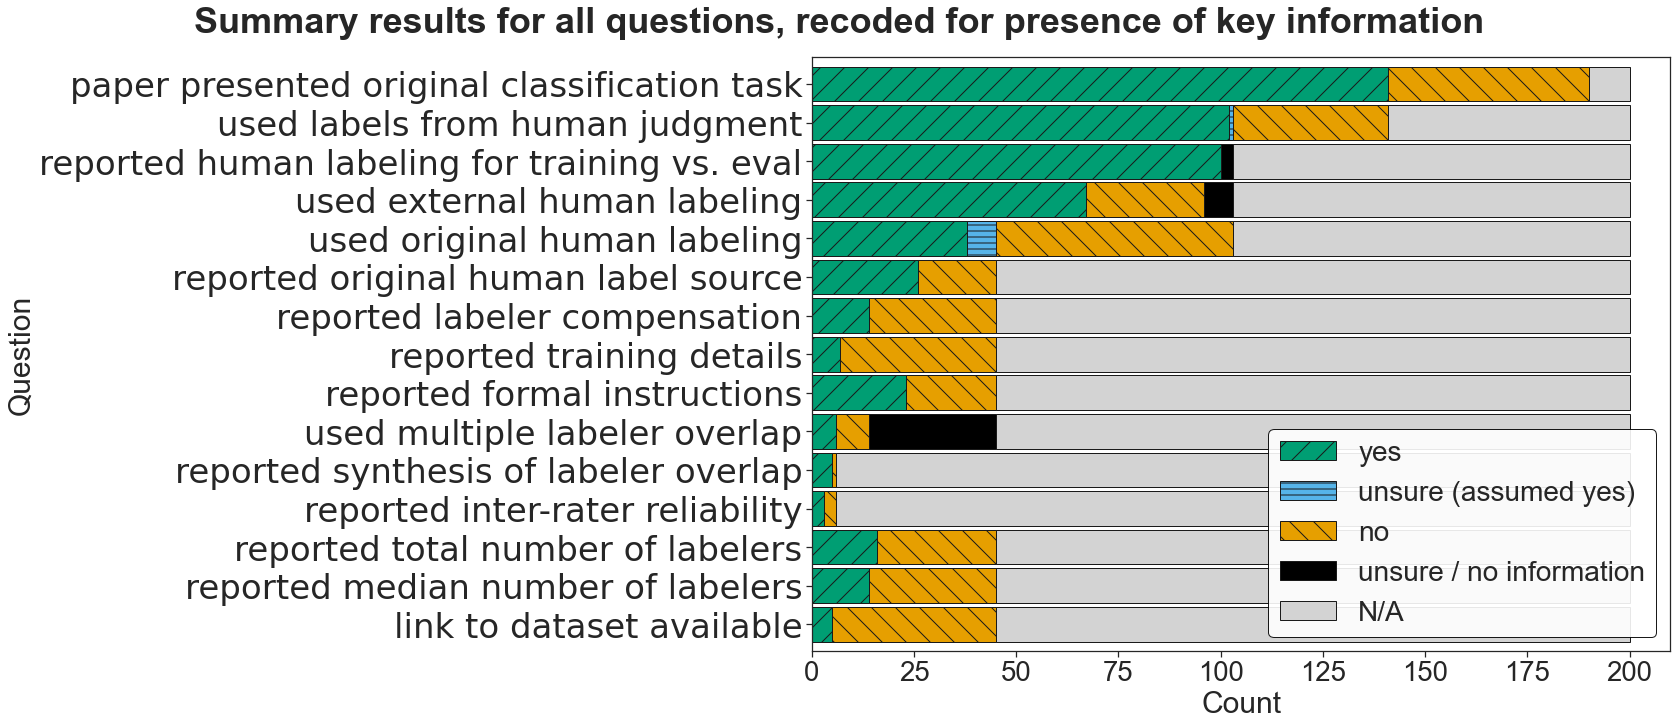

In [33]:
sns.set(style="ticks", font_scale=2.5)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=[24,11])

results_df.iloc[::-1].plot(kind='barh',stacked=True,ax=ax,width=.9,
                           color=["#009E73","#56B4E9","#E69F00","black","lightgrey"] # from a colorblind-sensitive palette
                          )

ax.set_xlabel("Count")
ax.set_ylabel("Question")

plt.suptitle("Summary results for all questions, recoded for presence of key information",
             ha="center",y=.94,fontweight="bold")

font_props = {'family' : 'liberation sans',
              'weight' : 'regular',
              'size'   : 34}

ax.set_yticklabels(['link to dataset available',
 'reported median number of labelers',
 'reported total number of labelers',
 'reported inter-rater reliability',
 'reported synthesis of labeler overlap',
 'used multiple labeler overlap',
 'reported formal instructions',
 'reported training details',
 'reported labeler compensation',
 'reported original human label source',
 'used original human labeling',
 'used external human labeling',
 'reported human labeling for training vs. eval',
 'used labels from human judgment',
 'paper presented original classification task'])
        
for label in ax.get_yticklabels():
    label.set_font(font_props)

for i, patch in enumerate(ax.patches):
    patch.set_edgecolor("k")
    if patch.get_fc() == (0.0, 0.6196078431372549, 0.45098039215686275, 1.0):
        patch.set_hatch('/')
    elif patch.get_fc() == (0.0, 0.0, 0.0, 1.0):
        patch.set_hatch('')
    elif patch.get_fc() == (0.33725490196078434, 0.7058823529411765, 0.9137254901960784, 1.0):
        patch.set_hatch('--')
    elif patch.get_fc() == (0.9019607843137255, 0.6235294117647059, 0.0, 1.0):
        patch.set_hatch('\\')
    elif patch.get_fc() == (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 1.0):
        patch.set_hatch('')
plt.legend(fontsize=28,loc="lower right",framealpha=.9).get_frame().set_edgecolor("black")

plt.tight_layout()

plt.savefig("../figures/info_score_summary_wide.pdf", dpi=300, bbox_inches="tight")
plt.savefig("../figures/info_score_summary_wide.png", bbox_inches="tight")

### Scores viz

In [34]:
def change_width(ax, new_value) :
    # By https://thetopsites.net/article/59683826.shtml
    
    """
    Changes the bar width of an existing matplotlib axis
    
    Parameters:
        ax (matplotlib.axes): matplotlib axis object
        new_value (float): new bar width
    """
        
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

### The paper information score visualizations

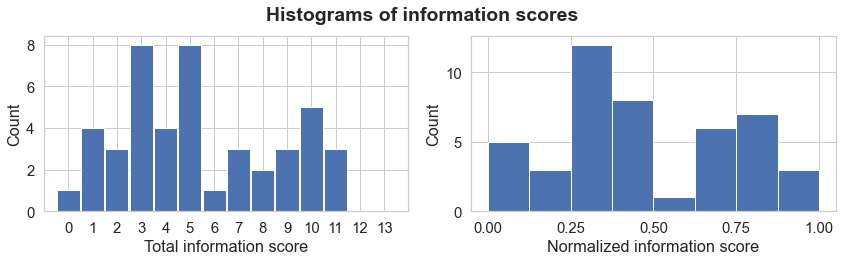

In [35]:
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
sns.set(style="whitegrid", font_scale=1.35)

# Create subplots

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=[12,4])

# First plot

df_original_ha['score'].value_counts().sort_index().plot(kind='bar',ax=ax[0])

ax[0].set_xlabel("Total information score")
ax[0].set_ylabel("Count")

ax[0].set_xlim(-1,14)
ax[0].set_xticks(range(0,14))

change_width(ax[0],.95)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(0)
    
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Second plot

sns.histplot(df_original_ha['norm score'].dropna(), ax=ax[1], bins=8, kde=False,alpha=1)

ax[1].set_xlabel("Normalized information score")
ax[1].set_ylabel("Count")

ax[1].set_xticks(np.arange(0,1.1,.25))

plt.suptitle("Histograms of information scores", ha="center",y=.92,fontweight="bold")

plt.tight_layout()

plt.savefig("../figures/info_score_raw_norm_hist.pdf", dpi=300, bbox_inches="tight")
plt.savefig("../figures/info_score_raw_norm_hist.png", bbox_inches="tight")

### Scores descriptive stats

In [36]:
df_original_ha['score'].mean()

5.4

In [37]:
df_original_ha['score'].median()

5.0

In [38]:
df_original_ha['score'].std()

3.222082894932745

In [39]:
df_original_ha['norm score'].mean()

0.4722610722610724

In [40]:
df_original_ha['norm score'].median()

0.45454545454545453

In [41]:
df_original_ha['norm score'].std()

0.26842913657287276

## Analysis and visualization for normalized information score by corpus
### Visualization

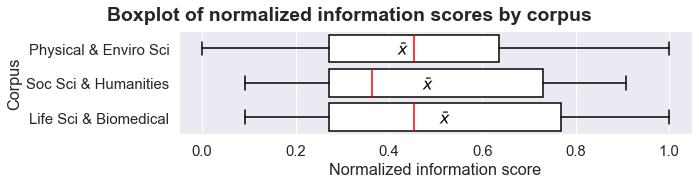

In [42]:
import matplotlib

sns.set(style="darkgrid", font_scale=1.35, rc={'figure.figsize':(10,3)})
medianprops = dict(linewidth=2.5, linecolor='firebrick')
boxcolors = dict(boxes='r', whiskers='r', medians='r', caps='r')
ax = sns.boxplot(data=df, x='norm score', y='Corpus', color='w', medianprops={'color':'red'},
                 showmeans=True,meanprops={"marker":"$x̄$","markerfacecolor":"black", 
                "markeredgecolor":"black","markeredgewidth":0,"markersize":"12"},
                order = list(df.groupby('Corpus')['norm score'].mean().dropna().sort_values().index))

ax.set_xlabel("Normalized information score")
ax.set_ylabel("Corpus")

for l in ax.get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')
            

plt.suptitle("Boxplot of normalized information scores by corpus",
             ha="center",y=.87,fontweight="bold")
plt.tight_layout()
plt.savefig("../figures/info_score_norm_corpus.png", bbox_inches="tight")
plt.savefig("../figures/info_score_norm_corpus.pdf", bbox_inches="tight")

### ANOVA for norm score by corpus

Show descriptive statistics, check for difference between variances

In [43]:
df_original_ha.groupby('Corpus')['norm score'].mean()

Corpus
Life Sci & Biomedical    0.519096
Physical & Enviro Sci    0.427807
Soc Sci & Humanities     0.482051
Name: norm score, dtype: float64

In [44]:
df_original_ha.groupby('Corpus')['norm score'].median()

Corpus
Life Sci & Biomedical    0.454545
Physical & Enviro Sci    0.454545
Soc Sci & Humanities     0.363636
Name: norm score, dtype: float64

In [45]:
df_original_ha.groupby('Corpus')['norm score'].std()

Corpus
Life Sci & Biomedical    0.267586
Physical & Enviro Sci    0.279767
Soc Sci & Humanities     0.266633
Name: norm score, dtype: float64

Check standard deviation max - min:

In [46]:
0.279767-0.266633

0.013133999999999979

Run ANOVA on norm score:

In [47]:
import scipy.stats as stats

In [48]:
stats.f_oneway(df_original_ha.query("Corpus == 'Life Sci & Biomedical'")['norm score'],
              df_original_ha.query("Corpus == 'Physical & Enviro Sci'")['norm score'],
              df_original_ha.query("Corpus == 'Soc Sci & Humanities'")['norm score'])

F_onewayResult(statistic=0.429537555582508, pvalue=0.6536366671000473)

## Analysis and visualization for normalized information score by classification outcome

### Visualization

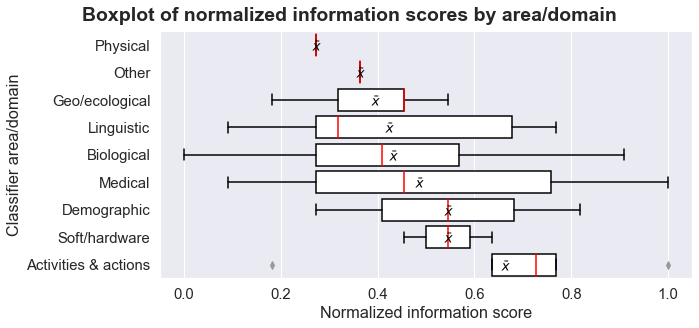

In [49]:
import matplotlib

sns.set(style="darkgrid", font_scale=1.35, rc={'figure.figsize':(10,5)})
medianprops = dict(linewidth=2.5, linecolor='firebrick')
boxcolors = dict(boxes='r', whiskers='r', medians='r', caps='r')
ax = sns.boxplot(data=df[['classification outcome','norm score']].dropna(),
                 x='norm score', y='classification outcome',
                 color='w',  medianprops={'color':'red'},
                 order = list(df.groupby('classification outcome')['norm score'].mean().dropna().sort_values().index),                 
                 showmeans=True,meanprops={"marker":"$x̄$","markerfacecolor":"black", 
                                          "markeredgecolor":"black","markeredgewidth":0,
                                          "markersize":"10"})

ax.set_xlabel("Normalized information score")
ax.set_ylabel("Classifier area/domain")

for l in ax.get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')
            
    
plt.suptitle("Boxplot of normalized information scores by area/domain",
             ha="center",y=.92,fontweight="bold")
plt.tight_layout()
plt.savefig("../figures/info_score_norm_area.png", bbox_inches="tight")
plt.savefig("../figures/info_score_norm_area.pdf", bbox_inches="tight")

### Descriptive statistics:

In [50]:
df[['classification outcome','norm score']].dropna().groupby('classification outcome').var()

,norm score
classification outcome,
Activities & actions,0.090308
Biological,0.139807
Demographic,0.148760
Geo/ecological,0.018733
Linguistic,0.072182
Medical,0.088947
Other,NaN
Physical,NaN
Soft/hardware,0.016529


In [51]:
df[['classification outcome','norm score']].dropna().groupby('classification outcome').std()

,norm score
classification outcome,
Activities & actions,0.300512
Biological,0.373908
Demographic,0.385695
Geo/ecological,0.136868
Linguistic,0.268668
Medical,0.298240
Other,NaN
Physical,NaN
Soft/hardware,0.128565


Calculate standard deviation max - min:

In [52]:
0.385695 - 0.128565

0.25712999999999997

That's pretty big! Not going to run an ANOVA, then.

## Visualizations for label source score
### Visualization for label source score by corpus

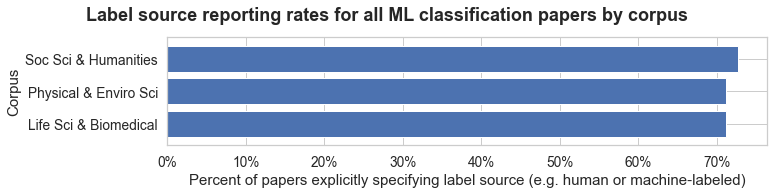

In [53]:
sns.set(style="whitegrid", font_scale=1.25)

ax = df.groupby('Corpus')['label source score'].mean().sort_values().plot(kind='barh', figsize=(11,3),width=.8)

ax.set_xlabel("Percent of papers explicitly specifying label source (e.g. human or machine-labeled)")

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.suptitle("Label source reporting rates for all ML classification papers by corpus",
             ha="center",y=.91,fontweight="bold")

plt.tight_layout()

plt.savefig("../figures/source_rates_corpus.pdf", bbox_inches="tight")
plt.savefig("../figures/source_rates_corpus.png", bbox_inches="tight")

### Visualization for label source score by classifier area/domain


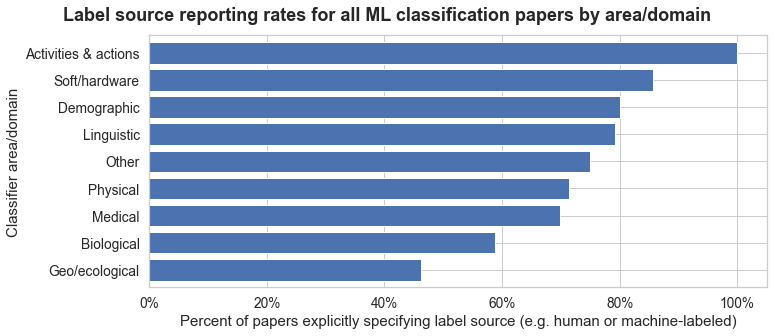

In [54]:
sns.set(style="whitegrid", font_scale=1.25)

ax = df.groupby('classification outcome')['label source score'].mean().sort_values().dropna().plot(kind='barh', figsize=(11,5),width=.8)

ax.set_xlabel("Percent of papers explicitly specifying label source (e.g. human or machine-labeled)")
ax.set_ylabel("Classifier area/domain")

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.suptitle("Label source reporting rates for all ML classification papers by area/domain",
             ha="center",y=.94,fontweight="bold")

plt.tight_layout()

plt.savefig("../figures/source_rates_area.pdf", bbox_inches="tight")
plt.savefig("../figures/source_rates_area.png", bbox_inches="tight")

In [55]:
df[['classification outcome','label source score']].dropna().groupby('classification outcome').var()

,label source score
classification outcome,
Activities & actions,0.000000
Biological,0.257353
Demographic,0.200000
Geo/ecological,0.269231
Linguistic,0.172101
Medical,0.215947
Other,0.250000
Physical,0.219780
Soft/hardware,0.131868


### Visualization for label source score by document type


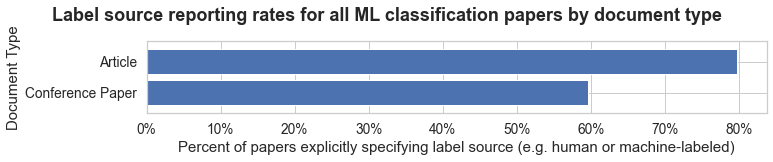

In [56]:
sns.set(style="whitegrid", font_scale=1.25)

ax = df.groupby('Document Type')['label source score'].mean().sort_values().plot(kind='barh', figsize=(11,2.5),width=.8)

ax.set_xlabel("Percent of papers explicitly specifying label source (e.g. human or machine-labeled)")

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.suptitle("Label source reporting rates for all ML classification papers by document type",
             ha="center",y=.91,fontweight="bold")

plt.tight_layout()

plt.savefig("../figures/source_rates_doc_type.pdf", bbox_inches="tight")
plt.savefig("../figures/source_rates_doc_type.png", bbox_inches="tight")

### Statistics for label source score by document type
Check variance diff:

In [57]:
df[['Document Type','label source score']].dropna().groupby('Document Type').var()

,label source score
Document Type,
Article,0.163368
Conference Paper,0.244987


In [58]:
0.244987-0.163368

0.081619

In [59]:
t = stats.ttest_ind(df_original_ha.query("`Document Type` == 'Article'")['label source score'],
              df_original_ha.query("`Document Type` == 'Conference Paper'")['label source score'],
               equal_var=False)
t

Ttest_indResult(statistic=2.3466162723196606, pvalue=0.033781482000389426)

## Analysis and visualization for normalized information score by document type
### Visualization

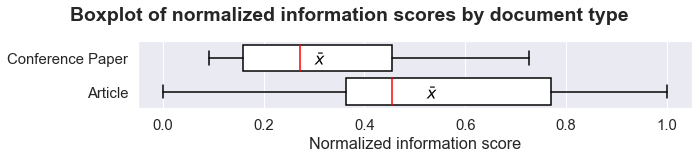

In [60]:
import matplotlib

sns.set(style="darkgrid", font_scale=1.35, rc={'figure.figsize':(10,2.5)})
medianprops = dict(linewidth=2.5, linecolor='firebrick')
boxcolors = dict(boxes='r', whiskers='r', medians='r', caps='r')
ax = sns.boxplot(data=df, x='norm score', y='Document Type', color='w', medianprops={'color':'red'},
                 showmeans=True,meanprops={"marker":"$x̄$","markerfacecolor":"black", 
                "markeredgecolor":"black","markeredgewidth":0,"markersize":"12"},
                order = list(df.groupby('Document Type')['norm score'].mean().dropna().sort_values().index))

ax.set_xlabel("Normalized information score")
ax.set_ylabel("")

for l in ax.get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')
            

plt.suptitle("Boxplot of normalized information scores by document type",
             ha="center",y=.9,fontweight="bold")
plt.tight_layout()
plt.savefig("../figures/info_score_doc_type.png", bbox_inches="tight")
plt.savefig("../figures/info_score_doc_type.pdf", bbox_inches="tight")

### T test for norm score by doc type

Show descriptive statistics, check for difference between variances

In [61]:
df_original_ha['Document Type'].value_counts()

Article             33
Conference Paper    12
Name: Document Type, dtype: int64

In [62]:
df_original_ha.groupby('Document Type')['norm score'].mean()

Document Type
Article             0.531045
Conference Paper    0.310606
Name: norm score, dtype: float64

In [63]:
df_original_ha.groupby('Document Type')['norm score'].median()

Document Type
Article             0.454545
Conference Paper    0.272727
Name: norm score, dtype: float64

In [64]:
df_original_ha.groupby('Document Type')['norm score'].std()

Document Type
Article             0.264535
Conference Paper    0.213934
Name: norm score, dtype: float64

In [65]:
df_original_ha.groupby('Document Type')['norm score'].var()

Document Type
Article             0.069979
Conference Paper    0.045768
Name: norm score, dtype: float64

Check variance max - min:

In [66]:
0.069979-0.045768

0.024210999999999996

Run 2-sided t test on norm score

In [67]:
import scipy.stats as stats

In [68]:
stats.ttest_ind(df_original_ha.query("`Document Type` == 'Article'")['norm score'],
              df_original_ha.query("`Document Type` == 'Conference Paper'")['norm score'],
               equal_var=False)

Ttest_indResult(statistic=2.861504179173963, pvalue=0.00858711759769932)

## Export processed dataset

In [69]:
df.to_excel("../data/final_labels_hashed_with_scores.xlsx",index=False)
df.to_csv("../data/final_labels_hashed_with_scores.tsv",sep="\t",index=False)